## 1.4 Dataset

In [1]:
import os
import sys
import random
import shutil

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Path

In [2]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
!gdown 1D7Y4PfVr5bEmeBixKuY6xlYKKuOXUWZe

Downloading...
From: https://drive.google.com/uc?id=1D7Y4PfVr5bEmeBixKuY6xlYKKuOXUWZe
To: /content/Dataset_stone.zip
100% 1.86G/1.86G [00:08<00:00, 209MB/s]


In [4]:
!unzip /content/Dataset_stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Masks/mask_63988.png  
  inflating: Dataset/Masks/mask_63989.png  
  inflating: Dataset/Masks/mask_6399.png  
  inflating: Dataset/Masks/mask_63990.png  
  inflating: Dataset/Masks/mask_63991.png  
  inflating: Dataset/Masks/mask_63992.png  
  inflating: Dataset/Masks/mask_63993.png  
  inflating: Dataset/Masks/mask_63994.png  
  inflating: Dataset/Masks/mask_63995.png  
  inflating: Dataset/Masks/mask_63996.png  
  inflating: Dataset/Masks/mask_63997.png  
  inflating: Dataset/Masks/mask_63998.png  
  inflating: Dataset/Masks/mask_63999.png  
  inflating: Dataset/Masks/mask_64.png  
  inflating: Dataset/Masks/mask_640.png  
  inflating: Dataset/Masks/mask_6400.png  
  inflating: Dataset/Masks/mask_64000.png  
  inflating: Dataset/Masks/mask_64001.png  
  inflating: Dataset/Masks/mask_64002.png  
  inflating: Dataset/Masks/mask_64003.png  
  inflating: Dataset/Masks/mask_64004.png  
  inflating: Dataset/Masks/mask_

## Data Generator

In [5]:
import os
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
 
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
    
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

IMAGE_PATH = '/content/Dataset/Images/'
MASK_PATH = '/content/Dataset/Masks/'

train_image_ids = os.listdir(IMAGE_PATH)
train_mask_ids = os.listdir(IMAGE_PATH)

X = np.zeros((len(train_image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 
             dtype=np.uint8)
y = np.zeros((len(train_image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')
for n, id_ in enumerate(train_image_ids):   
    img = imread(IMAGE_PATH + id_)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 
                 mode='constant', preserve_range=True)
    X[n] = img

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    mask_file = id_.replace("image_", "mask_")
    mask_ = imread(MASK_PATH + mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), 
                                  mode='constant',  
                                  preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)  
            
    y[n] = mask

print("Done")

Resizing training images and masks
Done


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
image_x = random.randint(0, len(X_train))
plt.axis("off")
imshow(X_train[image_x])
plt.show()
plt.axis("off")
imshow(np.squeeze(y_train[image_x]))
plt.show()

## UNet

In [7]:
def UNet():
    num_classes = 1

    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
    
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)
    
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.ReLU()(u9)
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [14]:
model = UNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 128, 128, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_10 (Dropout)           (None, 128, 128, 16  0           ['conv2d_22[0][0]']              
                                )                                                           

## Training

In [15]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), 
                    batch_size=32, epochs=2, callbacks=callbacks)

Epoch 1/2
1422/1422 [==============================] - 43s 25ms/step - loss: 0.0410 - accuracy: 0.9921 - auc: 0.9674 - val_loss: 0.0107 - val_accuracy: 0.9963 - val_auc: 0.9923
Epoch 2/2
1422/1422 [==============================] - 35s 25ms/step - loss: 0.0073 - accuracy: 0.9975 - auc: 0.9975 - val_loss: 0.0050 - val_accuracy: 0.9982 - val_auc: 0.9977


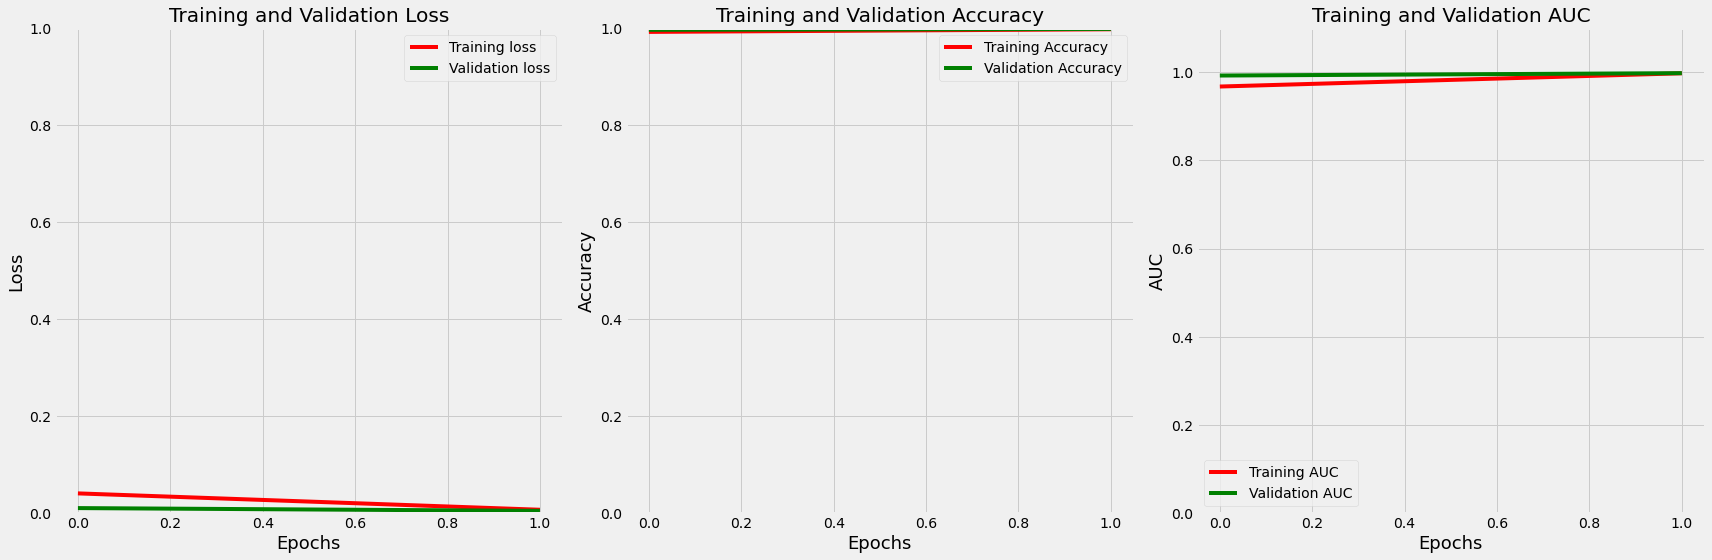

In [16]:
def plot_auc_acc_loss(history, epochs):
    tacc = history.history['accuracy']
    tloss = history.history['loss']
    tauc = history.history['auc']

    vacc = history.history['val_accuracy']
    vloss = history.history['val_loss']
    vauc = history.history['val_auc']

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    axes[0].plot(tloss, 'r', label='Training loss')
    axes[0].plot(vloss, 'g', label='Validation loss')
    axes[0].set_ylim(0, 1)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(tacc, 'r', label='Training Accuracy')
    axes[1].plot(vacc, 'g', label='Validation Accuracy')
    axes[1].set_ylim(0, 1)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    axes[2].plot(tauc, 'r', label='Training AUC')
    axes[2].plot(vauc, 'g', label='Validation AUC')
    axes[2].set_ylim(0, 1.1)
    axes[2].set_title('Training and Validation AUC')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('AUC', fontsize=18)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    return Epochs

Epochs = plot_auc_acc_loss(history, epochs=2)

1/1 [==============================] - 0s 24ms/step


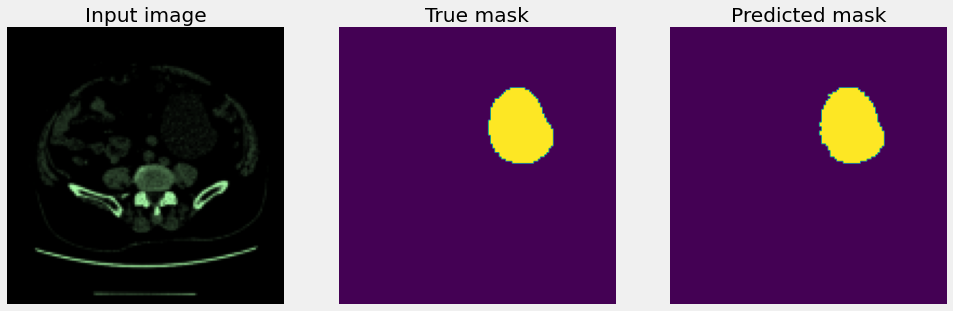

In [23]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]
prediction = model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])